In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
ENV["LINES"] = 9 # truncate IJulia display

9

# Julia DESC Live Demo

By Zack Li & Marius Millea

(this talk draws heavily on rdeits/DetroitTechWatch2020.jl)

* What is Julia?
* Language basics
* Julia is fast!
* Automatic differentiation, GPUs, machine learning
* Get more science done with Julia

# What is Julia?

* We want the speed of C.
* We want to write in the obvious, familiar mathematical notation.
* We want a language usable for general programming like Python
* We want it interactive and we want it compiled.


(Did we mention it should be as fast as C?)


*From https://julialang.org/blog/2012/02/why-we-created-julia/*

# The Basics

Arithmetic

In [2]:
2 + 3

5

Strings:

In [3]:
# Strings
print("hello DESC")

hello DESC

Arrays:

In [4]:
A = [1, 2, 3, 4]

4-element Vector{Int64}:
 1
 2
 3
 4

# Functions

Functions in Julia are "generic" by default. They accept any type.

In [5]:
function square(x)
    return x * x 
end

square (generic function with 1 method)

In [6]:
square(2)

4

In [7]:
square("hello")

"hellohello"

# Why is Julia fast?

Julia will compile native-machine code into memory, right when it is needed, also known as Just-In-Time (JIT) compilation.

In [8]:
square(2)

4

In [9]:
@code_native square(2)

	.text
; ┌ @ In[5]:1 within `square'
	movq	%rdi, %rax
; │ @ In[5]:2 within `square'
; │┌ @ int.jl:88 within `*'
	imulq	%rdi, %rax
; │└
	retq
	nopl	(%rax,%rax)
; └


These are x86 *hardware instructions*. This function has been compiled into the same form that a C or Fortran function would be.

In [10]:
A = [9.0  1.5  2.0;
     0.5  8.0  1.0;
     1.0  2.5  6.0]

square(A)

3×3 Matrix{Float64}:
 83.75  30.5   31.5
  9.5   67.25  15.0
 16.25  36.5   40.5

# Types

Julia can compile code dynamically because it is **typed**. The compiler is able to generate optimized machine code as long as it knows what types are involved.

In [11]:
typeof(2.0)

Float64

# Loops 

To perform elementwise operations on vectors, we could write a simple loop.

In [12]:
function elementwise_square_vector(v)
    # make an array of the same size
    result = similar(v) 
    
    # loop over and square each element
    for i in 1:length(v)
        result[i] = v[i]^2
    end
    
    return result
end

elementwise_square_vector([1, 2, 3])

3-element Vector{Int64}:
 1
 4
 9

Julia has a special "dot" syntax (called broadcasting), which performs elementwise operations.

In [13]:
x = [1, -2, 3]

x .^ 2

3-element Vector{Int64}:
 1
 4
 9

Broadcasting extends to arbitirary functions. A common function used in machine learning is the relu, defined as $$
\text{relu}(x) = \begin{cases}
    x     & x > 0 \\
    0,              & \text{otherwise}.
\end{cases}$$

In [14]:
function relu(x)
    if x > 0
        x
    else
        zero(x)   # a "0" of the same type as x
    end
end

relu (generic function with 1 method)

In [15]:
relu.(x)

3-element Vector{Int64}:
 1
 0
 3

# Package Management

Julia has an excellent package manager. To access the methods of a package, just write `using`. 

In [16]:
using LinearAlgebra

A = [9.0  1.5  2.0;
     0.5  8.0  1.0;
     1.0  2.5  6.0]

det(A)

393.0

# Python Interoperation

You can easily call Python from Julia, and similarly call Julia from Python. There is also a nicer wrapping of matplotlib called `PyPlot` which lets you use the plotting syntax you're used to.

In [17]:
using PyPlot; PyPlot.svg(true);  # I develop on a hidpi screen

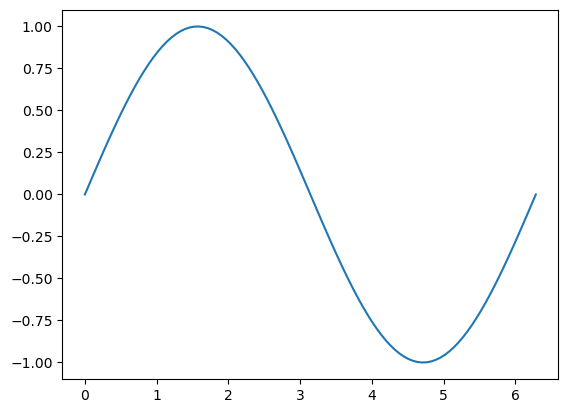

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8acfbc6340>

In [18]:
using PyPlot
x = LinRange(0, 2π, 100)  
plt.plot(x, sin.(x))

For other Python packages, you can use the `PyCall` package.

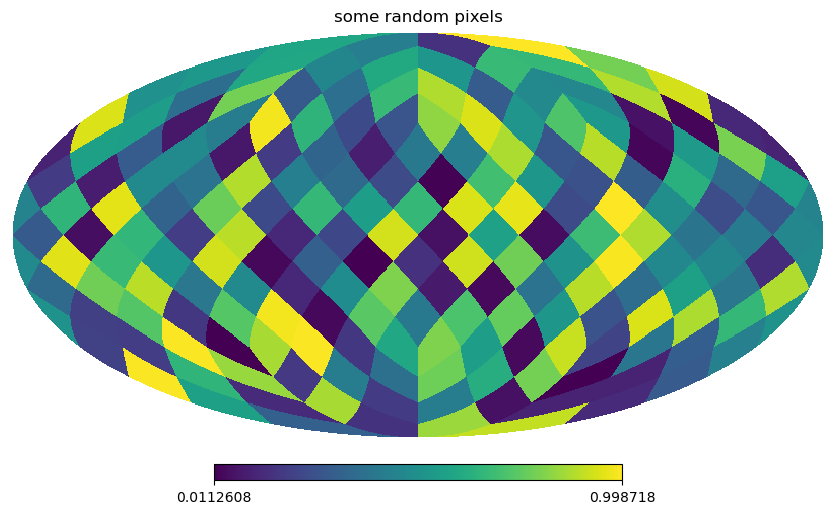

In [19]:
using PyCall
hp = pyimport("healpy")

hp.mollview(rand(192), title="some random pixels")

# Multithreading

Julia's multithreading can be as simple as adding `@threads` to a loop.

In [20]:
function threaded_relu(v)
    result = similar(v)
    Threads.@threads for i in 1:length(v)
        result[i] = relu(v[i])
    end
    return result
end

x = [1, -2, 3, -4, 5, 6]
threaded_relu(x)

6-element Vector{Int64}:
 1
 0
 ⋮
 5
 6

# Composability

Julia is remarkably composable, because you can define the methods that operate on a type without owning the type. For example, let's solve the simple ODE,

$$ \frac{du}{dt} = \alpha u .$$

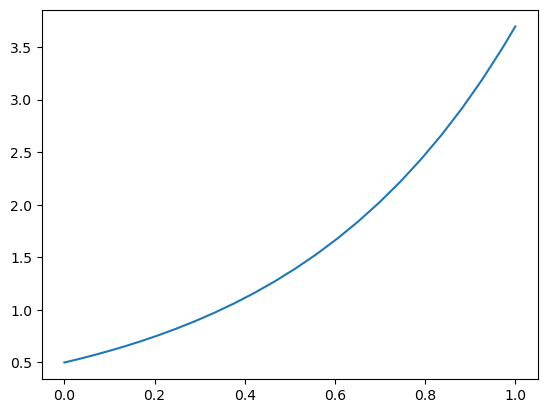

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ac95ed5e0>

In [21]:
using OrdinaryDiffEq

α = 2.0
u0 = 0.5            # initial value
f(u, p, t) = α * u

prob = ODEProblem(f, u0, (0.0, 1.0))
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
plt.plot(sol.t, sol.u)

Now let's load in a type from the Measurements package, which lets us express a quantity and an uncertainty. What if we are uncertain about the initial value, $u(0)$?

In [22]:
α = 1.01
u0 = 0.5 ± 0.1            # initial value
f(u, p, t) = α * u
prob = ODEProblem(f, u0, (0.0, 1.0))
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

sol.u

LoadError: UndefVarError: ± not defined

# Automatic Differentiation

Julia has many different packages for automatic differentiation (AD). The kind of AD that comes up most often in Bayesian inference or machine learning is called "reverse mode," which is the most efficient when you are taking the derivative of a scalar function (like a "loss" or a "posterior probability") with respect to many inputs. 

Julia's reverse-mode source-to-source AD package is called Zygote.

In [46]:
using Zygote

In [4]:
Zygote.gradient(f, x::Union{Number,AbstractArray}) = Base.invoke(Zygote.gradient, Tuple{Any,Any}, f, x)[1]

Simple things work like you'd expect:

In [48]:
gradient((x -> sin(2x)), π)

2.0

This works through arbitrary Julia code. Here's a reminder of that `relu` function we defined before:

In [49]:
function relu(x)
    if x > 0
        x
    else
        zero(x)   # a "0" of the same type as x
    end
end

relu (generic function with 1 method)

We can use it (broadcasted across an array) in a loss function and take a gradient of the loss:

In [50]:
loss(x) = sum(relu.(x))
x = randn(1000)
gradient(loss, x)

1000-element Vector{Float64}:
 0.0
 1.0
 ⋮
 1.0
 1.0

An aside on JAX.
This does
not work in JAX:
```py
@jit
def relu(x):
    if x > 0:
        return x
    else:
        return 0.
```

You have to do:

```py
@jit
def relu(x):
    return lax.cond(x>0, lambda x: x, lambda x: 0., x)
```

This is fundamentally due to JAX being a "tracing" AD, whereas Zygote is "source-to-source". This type of thing is why I (MM) usually claim Julia AD works more transparently through any Julia arbitrary code. I don't think there's much JAX truly can't do, but I do think in some cases you're forced write things a bit obfuscated. See also: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

# GPU

In [41]:
using CUDA

`cu` moves objects like Arrays to (a CUDA) GPU:

In [51]:
x = cu(x)

1000-element CuArray{Float32, 1}:
 -1.314315
  0.1031893
  ⋮
  0.068978585
  1.11943

Then the same `loss` gradient works, but this happened on GPU:

In [52]:
gradient(loss, x)

1000-element CuArray{Float32, 1}:
 0.0
 1.0
 ⋮
 1.0
 1.0

Note that as part of that computation, our user-defined Julia function `relu` was compiled to a GPU kernel. You can look at that code if you like:

In [58]:
@device_code_sass relu.(x)

// PTX CompilerJob of kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceVector{Float32, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, typeof(relu), Tuple{Base.Broadcast.Extruded{CuDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Int64) for sm_50

	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_64BIT_ADDRESS EF_CUDA_SM50 EF_CUDA_VIRTUAL_SM(EF_CUDA_SM50)"
	.elftype	@"ET_EXEC"


//--------------------- .text._Z28julia_broadcast_kernel_1240115CuKernelContext13CuDeviceArrayI7Float32Li1ELi1EE11BroadcastedIv5TupleI5OneToI5Int64EE5_reluS3_I8ExtrudedIS0_IS1_Li1ELi1EES3_I4BoolES3_IS5_EEEES5_ --------------------------
	.section	.text._Z28julia_broadcast_kernel_1240115CuKernelContext13CuDeviceArrayI7Float32Li1ELi1EE11BroadcastedIv5TupleI5OneToI5Int64EE5_reluS3_I8ExtrudedIS0_IS1_Li1ELi1EES3_I4BoolES3_IS5_EEEES5_,"ax",@progbits
	.sectioninfo	@"SHI_REGISTERS=29"
	.align	32
        .global         _Z28julia_broadcast_kernel_1240115CuKernelContext13CuDeviceArrayI7Float32

        IADD RZ.CC, R24, -c[0x0][0x150] ;
        ISETP.GT.X.AND P0, PT, R23, c[0x0][0x154], PT ;
   @!P0 BRA `(.L_11) ;
        NOP ;
        NOP ;
        EXIT ;
        .type           $_Z28julia_broadcast_kernel_1240115CuKernelContext13CuDeviceArrayI7Float32Li1ELi1EE11BroadcastedIv5TupleI5OneToI5Int64EE5_reluS3_I8ExtrudedIS0_IS1_Li1ELi1EES3_I4BoolES3_IS5_EEEES5_$gpu_report_exception,@function
        .size           $_Z28julia_broadcast_kernel_1240115CuKernelContext13CuDeviceArrayI7Float32Li1ELi1EE11BroadcastedIv5TupleI5OneToI5Int64EE5_reluS3_I8ExtrudedIS0_IS1_Li1ELi1EES3_I4BoolES3_IS5_EEEES5_$gpu_report_exception,($_Z28julia_broadcast_kernel_1240115CuKernelContext13CuDeviceArrayI7Float32Li1ELi1EE11BroadcastedIv5TupleI5OneToI5Int64EE5_reluS3_I8ExtrudedIS0_IS1_Li1ELi1EES3_I4BoolES3_IS5_EEEES5_$gpu_signal_exception - $_Z28julia_broadcast_kernel_1240115CuKernelContext13CuDeviceArrayI7Float32Li1ELi1EE11BroadcastedIv5TupleI5OneToI5Int64EE5_reluS3_I8ExtrudedIS0_IS1_Li1ELi1EES3_I4BoolES3_

# Machine Learning

In [59]:
dense_layer(W, b, x) = W * x + b

dense_layer (generic function with 1 method)

In [60]:
W = cu(randn(1000, 1000))
b = cu(randn(1000));

In [64]:
(dW, dB) = gradient((W,b) -> loss(dense_layer(W,b,x)), W, b);

In [65]:
dW

1000×1000 CuArray{Float32, 2}:
 -0.0      0.0       -0.0       -0.0       …  -0.0       0.0        0.0
 -0.0      0.0       -0.0       -0.0          -0.0       0.0        0.0
  ⋮                                        ⋱                        
 -0.0      0.0       -0.0       -0.0          -0.0       0.0        0.0
 -1.31431  0.103189  -0.960796  -0.235977     -0.311886  0.0689786  1.11943

In [66]:
dB

1000-element CuArray{Float32, 1}:
 0.0
 0.0
 ⋮
 0.0
 1.0

# Julia AD is written in... Julia

Pullbacks/pushforwards are written in Julia, in the ChainRules.jl package:

![](chainrules.png)

If something doesn't exist or if I discover a mistake, since I already know Julia, I can define a new rule in my running session, and I can even do a PR to ChainRules.jl. In JAX/TensorFlow/PyTorch, etc... I wouldn't even know where to start (and I probably need to know C/C++). 

# CMBLensing.jl

![](posterior2.png)

In [68]:
using CMBLensing

In [69]:
@unpack f, ϕ, ds = load_sim(Nside=512, θpix=3, pol=:P, storage=CuArray);

In [88]:
dϕ = gradient(ϕ -> lnP(0, f, ϕ, ds), 0ϕ)

131584-element 512×512-pixel 3.0′-resolution FlatFourier{CuArray{ComplexF32,2},ProjLambert{Float32}}:
        0.0f0 + 0.0f0im
  2.1229732f9 - 2.6542725f9im
              ⋮
 -6.1471795f9 + 1.361623f10im
  1.5681175f9 + 1.4322087f10im

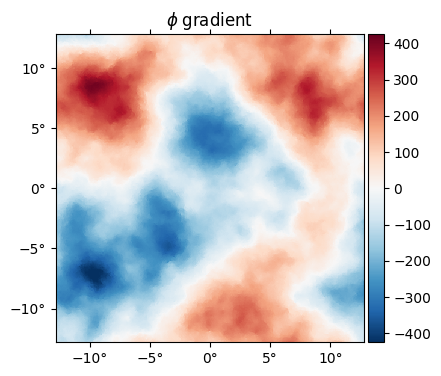

In [92]:
plot(∇² \ dϕ, title=L"\phi \; {\rm gradient}");

# Other interesting links

* *Useful Algorithms That Are Not Optimized By Jax, PyTorch, or Tensorflow* https://www.stochasticlifestyle.com/useful-algorithms-that-are-not-optimized-by-jax-pytorch-or-tensorflow/
* *The Unreasonable Effectiveness of Multiple Dispatch* (one of MM's favorite talks on the subject) https://www.youtube.com/watch?v=kc9HwsxE1OY
* JuliaCon talk in 5 days on the next-gen of Zygote called Diffractor which is (supposedly) even better: https://pretalx.com/juliacon2021/talk/7SQHJH/

# Conclusion